## TODOS:
* Conditional Training
* ~~Template matching~~
    * Using as a form of augmentation
* ~~Try label smoothing on each sample rather than a preprocessing step~~
    * Worse 
* Determine the best way to handle null (empty) labels
    * Appears to be constant 0
* Label propagation by patient-study
    * patient-study accomplishes nothing. Purely patient would be possible, however.
* AP/PA/Lateral ensemble (weight based on)
    * Completed 2 types of ensemble.
        1. Independently predict each grouping using the corresponding model trained on that group (~0.65 AUC)
        2. Simple weighted ensemble (~0.69 AUC)
* figure out if train can be split into new val set ()
    * Can and was
* thresholding
* weighted average / maximum 


## Cautions:
* ~~Currently setting No Findings = 1 if all others are nan or 0. Could be dangerous to do so, but will make AUC calculations easier~~
    * Preliminary findings suggest this should not be done.

## Useful discoveries
* There are 0 items that have `No Finding` = 1 and any of the disease categories in {-1,1}. There are `Support Devices`  = 1, however. 
* There are 28,480 that have 0's in all disease categories. Of those, 6099 have 0 in `No Finding` category. Of those, 4256 also have 0 in `Support Devices`
* Validation: 9 items all label=0, 39 items all-`Support Devices`=0, 77 items all-{`No Finding`,`Support Devices`}=0)
* 138,358 items in the training set do not contain a -1, 85,056 contain at least one -1
* 21 training samples contain 6 -1s
* There are no intra-patient-study label discrepancies, there are intra-patient label discrepancies


## Challenge Notes

For every **STUDY** in the input file (not every image), your program should output probabilities for each of the 5 competition tasks. The output file should be a 6-column CSV file with the following headers (order does not matter):

`Study, Atelectasis, Cardiomegaly, Consolidation, Edema, Pleural Effusion`

so each line of the file should look like:
```
CheXpert-v1.0/{valid,test}/<PATIENT>/<STUDY>,[0,1],[0,1],[0,1],[0,1],[0,1]
```

**Note to users of the low resolution dataset:** the test images on CodaLab are full resolution (and therefore will be input to your code at that resolution). 

**Please do not submit more than 2 models within a month.** If you do, 2 of your models will be **randomly selected** to be considered for the leaderboard, and the rest will be ignored.

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from chex import config as C

In [4]:
from chex.dataaug import get_transforms
from chex.dataload import CheXDataset, subset_dloader, get_dloaders
from chex.etl import proc_df, make_df_merged
from chex.inference import validation_ensemble, ensemble, predict_loader
from chex.modeling import CheXModel
from chex.plotting import show_batch, plot_learning_curves
from chex.saving import save_history, save_trained, load_trained, make_desc
from chex.training import Trainer, make_trainer
from chex.utils import seed_everything, recurse_children

#### Globals

In [5]:
USE_CUDA = True
ON_AWS = True
NUM_WORKERS = 8 if ON_AWS else 0

DEVICE = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')
C.set_config(USE_CUDA=USE_CUDA, ON_AWS=ON_AWS, NUM_WORKERS=NUM_WORKERS, DEVICE=DEVICE)

In [6]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

## Data

In [7]:
df_train = pd.read_csv(C.CHX_PATH/'train.csv')
df_valid = pd.read_csv(C.CHX_PATH/'valid.csv')

## Experiments

#### BW experiment

In [8]:
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(df_train, df_valid, 256, None, color=False)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'dn121_thawsteplr64bSig_{nsamp}k_BW'

criterion = nn.BCELoss()
model = CheXModel(arch,use_sig=True,as_gray=True)
#model = load_trained(model,'dn121_thawsteplr256bSig_223k_chkpnt.pt',device=DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

thaw_schd = {2:('norm5','denseblock4'),3:('transition3','denseblock3')}#,4:('transition2','denseblock2')}

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1,3,4,5], gamma=0.1, verbose=True)

trainer = Trainer(model, optimizer, criterion, scheduler, thaw_schd, device=DEVICE)
pstat = trainer.freeze(['_fc','fc','network.classifier','classifier',],invert_match=True)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=0.449, std=0.226, max_pixel_value=255.0)
--------------------

20

In [9]:
hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt', accum_steps=None)

save_desc = make_desc(train_loader,trainer,"5e, grayscale imgs densenet121, BCELoss with Sigmoid activation, thawMstep0.1")

save_history(trainer.history, savename, save_desc)

Score improved: 0.79013 > 0.00000
state dict saved to: save/models/dn121_thawsteplr64bSig_223k_BW_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [0] train_loss: 0.4071, train_auc: 0.7914, train_auc5: 0.6983, train_time: 776.4380, valid_loss: 0.4292, valid_auc: 0.7901, valid_auc5: 0.7087, valid_time: 5.3279


Score improved: 0.81228 > 0.79013
state dict saved to: save/models/dn121_thawsteplr64bSig_223k_BW_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [1] train_loss: 0.3808, train_auc: 0.8129, train_auc5: 0.7264, train_time: 770.0601, valid_loss: 0.4103, valid_auc: 0.8123, valid_auc5: 0.7265, valid_time: 1.6766
Trainable: 66, Frozen: 176


Score improved: 0.85925 > 0.81228
state dict saved to: save/models/dn121_thawsteplr64bSig_223k_BW_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [2] train_loss: 0.3609, train_auc: 0.8358, train_auc5: 0.7732, train_time: 948.5807, valid_loss: 0.3714, valid_auc: 0.8592, valid_auc5: 0.8151, valid_time: 1.6702
Trainable: 164, Frozen: 78


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [3] train_loss: 0.3424, train_auc: 0.8547, train_auc5: 0.8039, train_time: 1201.6431, valid_loss: 0.3649, valid_auc: 0.8569, valid_auc5: 0.8332, valid_time: 1.6817
Trainable: 214, Frozen: 28


RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 14.76 GiB total capacity; 13.78 GiB already allocated; 3.75 MiB free; 13.90 GiB reserved in total by PyTorch)

In [12]:
trainer.freeze(['transition2','denseblock2'], False, False);
scheduler_ = optim.lr_scheduler.MultiStepLR(trainer.optimizer, [1,3], gamma=0.1, verbose=True)
trainer_ = Trainer(trainer.model, trainer.optimizer, trainer.criterion, scheduler_, None, trainer.device)
trainer_.history = trainer.history
trainer_.optimizer.param_groups[0]['lr'] = 1e-3

Trainable: 164, Frozen: 78
Adjusting learning rate of group 0 to 1.0000e-05.


In [20]:
torch.cuda.empty_cache()

In [15]:
train_loader, valid_loader = get_dloaders(df_train, df_valid, 256, None, color=False)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=0.449, std=0.226, max_pixel_value=255.0)
--------------------

In [23]:
hist = trainer_.train(train_loader, valid_loader, 3, log_freq=10, save_name=f'{savename}_chkpnt', accum_steps=None)
save_desc = make_desc(train_loader,trainer_,"3e+3, grayscale imgs densenet121, BCELoss with Sigmoid activation, thawMstep0.1")
save_history(trainer_.history, savename, save_desc)

Score improved: 0.86873 > 0.85925
state dict saved to: save/models/dn121_thawsteplr64bSig_223k_BW_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [0] train_loss: 0.3434, train_auc: 0.8538, train_auc5: 0.8033, train_time: 1197.0654, valid_loss: 0.3580, valid_auc: 0.8687, valid_auc5: 0.8332, valid_time: 1.6779


Score improved: 0.86935 > 0.86873
state dict saved to: save/models/dn121_thawsteplr64bSig_223k_BW_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [1] train_loss: 0.3295, train_auc: 0.8669, train_auc5: 0.8203, train_time: 1197.3775, valid_loss: 0.3523, valid_auc: 0.8693, valid_auc5: 0.8513, valid_time: 1.6994


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [2] train_loss: 0.3258, train_auc: 0.8704, train_auc5: 0.8245, train_time: 1197.8769, valid_loss: 0.3528, valid_auc: 0.8679, valid_auc5: 0.8466, valid_time: 1.7179

File saved to: save/histories/dn121_thawsteplr64bSig_223k_BW.pkl


#### Try to reproduce best model

In [8]:
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(df_train, df_valid, 256, None)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'dn121_thawsteplr64bSig_{nsamp}k_reprod'

criterion = nn.BCELoss()
model = CheXModel(arch,use_sig=True)
#model = load_trained(model,'dn121_thawsteplr256bSig_223k_chkpnt.pt',device=DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

thaw_schd = {2:('norm5','denseblock4'),3:('transition3','denseblock3'),
             4:('transition2','denseblock2'),5:('transition1','denseblock1')}


scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [2,3,4,5], gamma=0.1, verbose=True)

trainer = Trainer(model, optimizer, criterion, scheduler, thaw_schd, device=DEVICE)
pstat = trainer.freeze(['_fc','fc','network.classifier','classifier',],invert_match=True)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

In [23]:
# successfully trained for epochs [0,1,2] OOM @ epoch 3
hist = trainer.train(train_loader, valid_loader, 6, log_freq=10, save_name=f'{savename}_chkpnt', accum_steps=None)

save_desc = make_desc(train_loader,trainer,"3e, reproduce densenet121, BCELoss with Sigmoid activation, thawMstep0.1")

save_history(trainer.history, savename, save_desc)

File saved to: save/histories/dn121_thawsteplr64bSig_223k_reprod.pkl


In [29]:
trainer.freeze(['transition2','denseblock2'], False, False);

In [41]:
scheduler_ = optim.lr_scheduler.MultiStepLR(trainer.optimizer, [1,3], gamma=0.1, verbose=True)
trainer_ = Trainer(trainer.model, trainer.optimizer, trainer.criterion, scheduler_, None, trainer.device)
trainer_.history = trainer.history
trainer_.optimizer.param_groups[0]['lr'] = 1e-4

Adjusting learning rate of group 0 to 1.0000e-04.


In [47]:
hist = trainer_.train(train_loader, valid_loader, 4, log_freq=10, save_name=f'{savename}_chkpnt', accum_steps=None)
save_desc = make_desc(train_loader,trainer_,"3+4e, reproduce densenet121, BCELoss with Sigmoid activation, thawMstep0.1")
save_history(trainer_.history, savename, save_desc)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [0] train_loss: 0.3354, train_auc: 0.8616, train_auc5: 0.8137, valid_loss: 0.3582, valid_auc: 0.8644, valid_auc5: 0.8459


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [1] train_loss: 0.3308, train_auc: 0.8663, train_auc5: 0.8199, valid_loss: 0.3548, valid_auc: 0.8615, valid_auc5: 0.8405


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch [2] train_loss: 0.3292, train_auc: 0.8678, train_auc5: 0.8218, valid_loss: 0.3576, valid_auc: 0.8578, valid_auc5: 0.8382


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch [3] train_loss: 0.3307, train_auc: 0.8670, train_auc5: 0.8210, valid_loss: 0.3556, valid_auc: 0.8571, valid_auc5: 0.8386

File saved to: save/histories/dn121_thawsteplr64bSig_223k_reprod.pkl


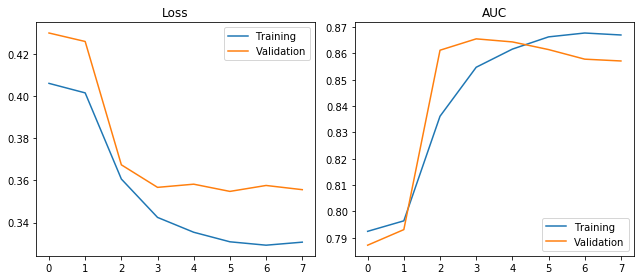

In [48]:
plot_learning_curves(trainer_.history)

In [52]:
prds = predict_loader(trainer_.model,valid_loader,False)

In [59]:
labs5 = valid_loader.dataset.labels[:, C.TARGET5_INDEX]

In [83]:
label_ranking_average_precision_score(valid_loader.dataset.labels,prds)

0.7661173798982863

In [50]:
def bn2gn(module, name='network', n_group=4):
    '''Recursively replace BatchNorm in nn.module module with GroupNorm.
    '''
    # go through all attributes of module nn.module (e.g. network or layer) and put batch norms if present
    for attr_str in dir(module):
        target_attr = getattr(module, attr_str)
        if type(target_attr) == torch.nn.BatchNorm2d:
            print('replaced: ', name, attr_str)
            gn = nn.GroupNorm(n_group, target_attr.num_features, affine=True)
            gn.weight = target_attr.weight
            gn.bias = target_attr.bias
            gn.eps = target_attr.eps
            setattr(module, attr_str, gn)

    # iterate through immediate child modules. Note, the recursion is done by our code no need to use named_modules()
    for name, immediate_child_module in module.named_children():
        bn2gn(immediate_child_module, name, n_group)

In [51]:
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(df_train, df_valid, 64, None)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'dn121_thawsteplr64bSig_{nsamp}k_gn4'

criterion = nn.BCELoss()
model = CheXModel(arch,use_sig=True)
#model = load_trained(model,'dn121_thawsteplr256bSig_223k_chkpnt.pt',device=DEVICE)
#model = load_trained(model,'dn121_thawsteplr256bSig_223k_resume_chkpnt.pt',device=DEVICE)
bn2gn(model, 'model', 4)
#model.half()
#model.network.classifier = nn.Sequential(nn.Linear(1024,14),)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

thaw_schd = {1:('norm5','denseblock4'),2:('transition3','denseblock3'),
             3:('transition2','denseblock2'),4:('transition1','denseblock1')}


scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1,2,3,4], gamma=0.1, verbose=True)

trainer = Trainer(model, optimizer, criterion, scheduler, thaw_schd, device=DEVICE)
pstat = trainer.freeze(['_fc','fc','network.classifier','classifier',],invert_match=True)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

In [53]:
hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt', accum_steps=4)

save_desc = "gn densenet121, BCELoss with Sigmoid activation, thawMstep0.1, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

Score improved: 0.78680 > 0.00000
state dict saved to: save/models/dn121_thawsteplr64bSig_223k_gn4_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [0] train_loss: 0.1045, train_auc: 0.7701, train_auc5: 0.6588, valid_loss: 0.4266, valid_auc: 0.7868, valid_auc5: 0.6829
Trainable: 66, Frozen: 176


Score improved: 0.79116 > 0.78680
state dict saved to: save/models/dn121_thawsteplr64bSig_223k_gn4_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [1] train_loss: 0.1015, train_auc: 0.7867, train_auc5: 0.6843, valid_loss: 0.4222, valid_auc: 0.7912, valid_auc5: 0.6762
Trainable: 164, Frozen: 78


KeyboardInterrupt: 

In [38]:
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(df_train, df_valid, 128, None)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'dn121_thawsteplr256bSig_{nsamp}k_gnresume'

criterion = nn.BCELoss()
model = CheXModel(arch,use_sig=True)
#model = load_trained(model,'dn121_thawsteplr256bSig_223k_chkpnt.pt',device=DEVICE)
model = load_trained(model,'dn121_thawsteplr256bSig_223k_resume_chkpnt.pt',device=DEVICE)
#model.half()
#model.network.classifier = nn.Sequential(nn.Linear(1024,14),)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# thaw_schd = {#1:('norm5','denseblock4'),2:('transition3','denseblock3'),
#              0:('transition2','denseblock2'),1:('transition1','denseblock1')}
thaw_schd = None#{#1:('norm5','denseblock4'),2:('transition3','denseblock3'),0:('transition2','denseblock2'),
            # 1:('transition1','denseblock1')}

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1,3], gamma=0.1, verbose=True)

trainer = Trainer(model, optimizer, criterion, scheduler, thaw_schd, device=DEVICE)
pstat = trainer.freeze(['_fc','fc','network.classifier','classifier','norm5','denseblock4','transition3','denseblock3','transition2','denseblock2'],invert_match=True)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

In [40]:
trainer = Trainer(model2, trainer.optimizer,trainer.criterion,trainer.scheduler,trainer.thaw_schedule,trainer.device)

In [41]:
hist = trainer.train(train_loader, valid_loader, 3, log_freq=10, save_name=f'{savename}_chkpnt', accum_steps=2)

save_desc = "resume gn densenet121, BCELoss with Sigmoid activation, thawMstep0.1, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

KeyboardInterrupt: 

In [58]:
%%time
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(df_train, df_valid, 256, None)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'dn121_thawsteplr256bSig_{nsamp}k'

criterion = nn.BCELoss()
model = CheXModel(arch,use_sig=True)

#model.network.classifier = nn.Sequential(nn.Linear(1024,14),)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

thaw_schd = {1:('norm5','denseblock4'),2:('transition3','denseblock3'),
             3:('transition2','denseblock2'),4:('transition1','denseblock1')}

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1,3,4], gamma=0.1, verbose=True)

trainer = Trainer(model, optimizer, criterion, scheduler, thaw_schd)
pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert_match=True)

hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "densenet121, BCELoss with Sigmoid activation, thawMstep0.1, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

RuntimeError: Found dtype Double but expected Float

In [67]:
save_desc = "densenet121, BCELoss with Sigmoid activation, thawMstep0.1, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(trainer.history['valid_auc']))
save_desc

'densenet121, BCELoss with Sigmoid activation, thawMstep0.1, samples 223414, batch 256, lr 1e-05, top val AUC 0.86719'

In [68]:
save_history(trainer.history, savename, save_desc)

File saved to: save/histories/dn121_thawsteplr256bSig_223k.pkl


In [63]:
trainer.optimizer.param_groups[0]['lr'] = 1e-3
hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "densenet121, BCELoss with Sigmoid activation, thawMstep0.1, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

Score improved: 0.81844 > 0.00000
state dict saved to: save/models/dn121_thawsteplr256bSig_223k_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [0] train_loss: 0.3797, train_auc: 0.8147, train_auc5: 0.7299, valid_loss: 0.4071, valid_auc: 0.8184, valid_auc5: 0.7437
Trainable: 66, Frozen: 176


Score improved: 0.84467 > 0.81844
state dict saved to: save/models/dn121_thawsteplr256bSig_223k_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [1] train_loss: 0.3649, train_auc: 0.8313, train_auc5: 0.7618, valid_loss: 0.3798, valid_auc: 0.8447, valid_auc5: 0.8086
Trainable: 164, Frozen: 78


Score improved: 0.86719 > 0.84467
state dict saved to: save/models/dn121_thawsteplr256bSig_223k_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [2] train_loss: 0.3482, train_auc: 0.8490, train_auc5: 0.7951, valid_loss: 0.3619, valid_auc: 0.8672, valid_auc5: 0.8532
Trainable: 214, Frozen: 28


RuntimeError: CUDA out of memory. Tried to allocate 450.00 MiB (GPU 0; 11.17 GiB total capacity; 9.77 GiB already allocated; 180.44 MiB free; 10.55 GiB reserved in total by PyTorch)

In [ ]:
%%time
arch = 'efnetb5'
train_loader, valid_loader = get_dloaders(32, None, seed=404)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'{arch}_thawsteplr_{nsamp}k'

criterion = nn.BCEWithLogitsLoss()
model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=14)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

thaw_schd = {1: ('_bn1','_conv_head'), 2:('_blocks.38',), 3:('_blocks.37',), 4:('_blocks.36',)}
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1,3,4], gamma=0.1, verbose=True)

trainer = Trainer(model, optimizer, criterion, scheduler, thaw_schd)
pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert_match=True)

hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "efficentnet-b5, thawMstep0.1, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

#### Train 5 Target Classes Only

In [78]:
#ct_cols = ['Path','Lung_Opacity','Consolidation','Edema','Atelectasis','Pneumonia']
df_ptrain = proc_df(df_train,'uones',True,0)
df_pvalid = proc_df(df_valid)[['Path']+TARGET_LABELS5]
df_ptrain = df_ptrain[['Path']+TARGET_LABELS5]#[ct_cols]

train_loader, valid_loader =get_ctdloaders(df_ptrain,df_pvalid,seed=404)
savename=f'dn121_5cls_thawsteplr'

thaw_schd = {1:('norm5','denseblock4'),2:('transition3','denseblock3'),
             3:('transition2','denseblock2'),4:('transition1','denseblock1')}

criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121',5)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
sched = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.3, verbose=True)

trainer = Trainer(model, optimizer, criterion, scheduler=sched, thaw_schedule=thaw_schd)
pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert_match=True)

hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "5 core class only, thawstep0.3, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  RandomCrop(always_apply=False, p=1.0, height=244, width=244),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, me

Score improved: 0.71433 > 0.00000
state dict saved to: save/models/dn121_5cls_thawsteplr_chkpnt.pt
Adjusting learning rate of group 0 to 3.0000e-04.
Epoch [0] train_loss: 0.5188, train_auc: 0.6959, valid_loss: 0.4937, valid_auc: 0.7143
Trainable: 66, Frozen: 176


Score improved: 0.82744 > 0.71433
state dict saved to: save/models/dn121_5cls_thawsteplr_chkpnt.pt
Adjusting learning rate of group 0 to 9.0000e-05.
Epoch [1] train_loss: 0.4783, train_auc: 0.7509, valid_loss: 0.4228, valid_auc: 0.8274
Trainable: 164, Frozen: 78


Score improved: 0.83262 > 0.82744
state dict saved to: save/models/dn121_5cls_thawsteplr_chkpnt.pt
Adjusting learning rate of group 0 to 2.7000e-05.
Epoch [2] train_loss: 0.4493, train_auc: 0.7850, valid_loss: 0.4185, valid_auc: 0.8326
Trainable: 214, Frozen: 28


Adjusting learning rate of group 0 to 8.1000e-06.
Epoch [3] train_loss: 0.4170, train_auc: 0.8205, valid_loss: 0.4274, valid_auc: 0.8242
Trainable: 240, Frozen: 2


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "

KeyboardInterrupt: 

In [79]:
save_desc = "5 core class only, thawstep0.3, 4epoch, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(trainer.history, savename, save_desc)
save_trained(trainer.model,savename,save_desc)

File saved to: save/histories/dn121_5cls_thawsteplr.pkl


state dict saved to: save/models/dn121_5cls_thawsteplr.pt


#### Conditional Training

In [51]:
#ct_cols = ['Path','Lung_Opacity','Consolidation','Edema','Atelectasis','Pneumonia']
df_ptrain = proc_df(df_train,'uones',True,0)
df_pvalid = proc_df(df_valid)
df_ptrain = df_ptrain[(df_ptrain[['Lung_Opacity','Consolidation']] == 1).all(1)]#[ct_cols]

train_loader, valid_loader =get_ctdloaders(df_ptrain,df_pvalid,seed=404)
savename=f'dn121_ct_5cls_nrm'

criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121',14)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, criterion, scheduler=None, thaw_schedule=None)
pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert_match=True)

hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "conditional training, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  RandomCrop(always_apply=False, p=1.0, height=244, width=244),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, me

Score improved: 0.65895 > 0.00000
state dict saved to: save/models/dn121_ct_5cls_nrm_chkpnt.pt
Epoch [0] train_loss: 0.3234, train_auc: 0.8973, valid_loss: 1.2642, valid_auc: 0.6590


Score improved: 0.66004 > 0.65895
state dict saved to: save/models/dn121_ct_5cls_nrm_chkpnt.pt
Epoch [1] train_loss: 0.3059, train_auc: 0.9085, valid_loss: 1.3701, valid_auc: 0.6600


Epoch [2] train_loss: 0.3007, train_auc: 0.9123, valid_loss: 1.4370, valid_auc: 0.6575


Epoch [3] train_loss: 0.2971, train_auc: 0.9151, valid_loss: 1.4722, valid_auc: 0.6596


Score improved: 0.66215 > 0.66004
state dict saved to: save/models/dn121_ct_5cls_nrm_chkpnt.pt
Epoch [4] train_loss: 0.2943, train_auc: 0.9171, valid_loss: 1.5309, valid_auc: 0.6621

File saved to: save/histories/dn121_ct_5cls_nrm.pkl


In [53]:
save_trained(trainer.model,'dn121_ct_5cls_nrm',save_desc)

state dict saved to: save/models/dn121_ct_5cls_nrm.pt


In [54]:
train_loader, valid_loader = get_dloaders(32,seed=404)
savename=f'dn121_ct_allcls'

#criterion = nn.BCEWithLogitsLoss()
# model = CheXModel('densenet121',14)
# model = load_trained(model2,'dn121_ct_5cls.pt')
# optimizer = optim.Adam(model2.parameters(), lr=1e-3)
trainer.scheduler = optim.lr_scheduler.StepLR(trainer.optimizer, 1, gamma=0.1, verbose=True)
#trainer = Trainer(model2, optimizer, criterion, scheduler=sched, thaw_schedule=None)
#pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert_match=True)

hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "conditional training, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  RandomCrop(always_apply=False, p=1.0, height=244, width=244),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, me

Score improved: 0.81337 > 0.00000
state dict saved to: save/models/dn121_ct_allcls_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [0] train_loss: 0.3993, train_auc: 0.7926, valid_loss: 0.4039, valid_auc: 0.8134


Score improved: 0.82050 > 0.81337
state dict saved to: save/models/dn121_ct_allcls_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [1] train_loss: 0.3859, train_auc: 0.8058, valid_loss: 0.3998, valid_auc: 0.8205


Score improved: 0.82513 > 0.82050
state dict saved to: save/models/dn121_ct_allcls_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-06.
Epoch [2] train_loss: 0.3848, train_auc: 0.8073, valid_loss: 0.3957, valid_auc: 0.8251


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch [3] train_loss: 0.3868, train_auc: 0.8064, valid_loss: 0.3961, valid_auc: 0.8160


Adjusting learning rate of group 0 to 1.0000e-08.
Epoch [4] train_loss: 0.3875, train_auc: 0.8061, valid_loss: 0.3968, valid_auc: 0.8134

File saved to: save/histories/dn121_ct_allcls.pkl


In [ ]:
df_ptrain[(df_ptrain[['Lung_Opacity','Consolidation']] == 1).all(1)][ct_cols]

In [51]:
%%time
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(32, None, seed=None)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'{arch}_thawsteplr_{nsamp}k'

thaw_schd = {1:('norm5','denseblock4'),2:('transition3','denseblock3'),
             3:('transition2','denseblock2'),4:('transition1','denseblock1')}

trainer = make_trainer(arch, 1e-3, 'steplr', thaw_schd)
hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "steplr, grad thaw, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  RandomCrop(always_apply=False, p=1.0, height=244, width=244),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, me

Score improved: 0.81810 > 0.00000
state dict saved to: save/models/densenet121_thawsteplr_223k_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [0] train_loss: 0.3989, train_auc: 0.7916, valid_loss: 0.4012, valid_auc: 0.8181


Score improved: 0.82309 > 0.81810
state dict saved to: save/models/densenet121_thawsteplr_223k_chkpnt.pt
Trainable: 66, Frozen: 176
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [1] train_loss: 0.3870, train_auc: 0.8045, valid_loss: 0.4006, valid_auc: 0.8231


Score improved: 0.83688 > 0.82309
state dict saved to: save/models/densenet121_thawsteplr_223k_chkpnt.pt
Trainable: 164, Frozen: 78
Adjusting learning rate of group 0 to 1.0000e-06.
Epoch [2] train_loss: 0.3810, train_auc: 0.8122, valid_loss: 0.3841, valid_auc: 0.8369


Trainable: 214, Frozen: 28
Adjusting learning rate of group 0 to 1.0000e-07.
Epoch [3] train_loss: 0.3786, train_auc: 0.8167, valid_loss: 0.3799, valid_auc: 0.8352


KeyboardInterrupt: 

In [52]:
save_trained(trainer.model, 'dn121_thawsteplr_223k_ep4.pt', save_path='save/models')

state dict saved to: save/models/dn121_thawsteplr_223k_ep4.pt


In [56]:
save_desc = "steplr, grad thaw, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(trainer.history['valid_auc']))
save_history(trainer.history, 'dn121_thawsteplr_223k_ep4', save_desc)

File saved to: save/histories/dn121_thawsteplr_223k_ep4.pkl


==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Cutout(always_apply=False, p=0.5, num_holes=8, max_h_size=8, max_w_size=8)
Normalize(always_apply=False

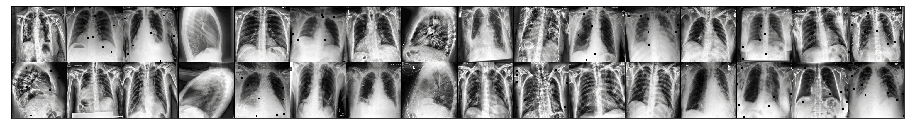

Adjusting learning rate of group 0 to 1.0000e-03.
Trainable: 2, Frozen: 362


Score improved: 0.82801 > 0.00000
state dict saved to: saves/models/densenet121_steplr_65k_chkpnt.pt
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [0] train_loss: 0.3914, train_auc: 0.8013, valid_loss: 0.4056, valid_auc: 0.8280


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch [1] train_loss: 0.3782, train_auc: 0.8176, valid_loss: 0.3968, valid_auc: 0.8264


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch [2] train_loss: 0.3769, train_auc: 0.8191, valid_loss: 0.3961, valid_auc: 0.8222


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch [3] train_loss: 0.3768, train_auc: 0.8193, valid_loss: 0.3958, valid_auc: 0.8238


Adjusting learning rate of group 0 to 1.0000e-08.
Epoch [4] train_loss: 0.3768, train_auc: 0.8193, valid_loss: 0.3970, valid_auc: 0.8209

File saved to: save/histories/densenet121_steplr_65k.pkl
CPU times: user 40min 27s, sys: 10min 9s, total: 50min 36s
Wall time: 48min 46s


In [461]:
%%time
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(32, 2**16, seed=404)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
savename=f'{arch}_steplr_{nsamp}k'

trainer = make_trainer(arch, 1e-3, train_loader, 'steplr')
hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "steplr, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist,savename, save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    CenterCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Cutout(always_apply=False, p=0.5, num_holes=8, max_h_size=8, max_w_size=8)
Normalize(always_apply=False

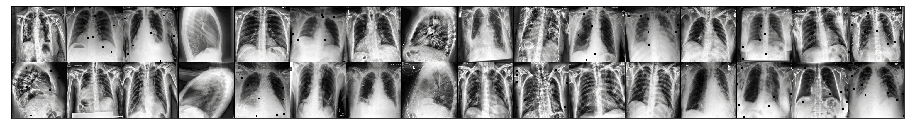

Trainable: 2, Frozen: 362


Score improved: 0.82897 > 0.00000
state dict saved to: saves/models/densenet121_131k_chkpnt.pt
Epoch [0] train_loss: 0.3885, train_auc: 0.8052, valid_loss: 0.3936, valid_auc: 0.8290


Score improved: 0.83033 > 0.82897
state dict saved to: saves/models/densenet121_131k_chkpnt.pt
Epoch [1] train_loss: 0.3838, train_auc: 0.8115, valid_loss: 0.3948, valid_auc: 0.8303


Epoch [2] train_loss: 0.3830, train_auc: 0.8126, valid_loss: 0.3920, valid_auc: 0.8294


Score improved: 0.83338 > 0.83033
state dict saved to: saves/models/densenet121_131k_chkpnt.pt
Epoch [3] train_loss: 0.3826, train_auc: 0.8132, valid_loss: 0.3908, valid_auc: 0.8334


Epoch [4] train_loss: 0.3822, train_auc: 0.8136, valid_loss: 0.3944, valid_auc: 0.8264

File saved to: save/histories/densenet121_131k.pkl
CPU times: user 1h 21min, sys: 20min 1s, total: 1h 41min 2s
Wall time: 1h 37min 16s


In [455]:
%%time
arch = 'densenet121'
train_loader, valid_loader = get_dloaders(32, 2**17, seed=404)
nsamp = str(len(train_loader.dataset)/1000).split('.')[0]
scheduler = optim.lr_scheduler.StepLR(opt, 1, gamma=0.1, verbose=True)
trainer = make_trainer(arch, 1e-3, train_loader)
hist = trainer.train(train_loader, valid_loader, 5, log_freq=10, save_name=f'{arch}_{nsamp}k_chkpnt')

save_desc = "samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist,f'{arch}_{nsamp}k', save_desc)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=0, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

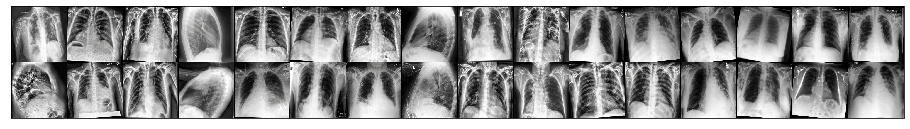

Trainable: 2, Frozen: 362


Score improved: 0.82639 > 0.00000
Epoch [0] train_loss: 0.3900, train_auc: 0.8030, valid_loss: 0.4032, valid_auc: 0.8264


Epoch [1] train_loss: 0.3828, train_auc: 0.8127, valid_loss: 0.4047, valid_auc: 0.8259


Epoch [2] train_loss: 0.3815, train_auc: 0.8145, valid_loss: 0.4006, valid_auc: 0.8257


Score improved: 0.82831 > 0.82639
Epoch [3] train_loss: 0.3808, train_auc: 0.8154, valid_loss: 0.3996, valid_auc: 0.8283


Epoch [4] train_loss: 0.3804, train_auc: 0.8160, valid_loss: 0.4077, valid_auc: 0.8190

File saved to: save/histories/densenet121_65k.pkl
state dict saved to: save/models/densenet121_65k.pt
CPU times: user 40min 46s, sys: 10min 4s, total: 50min 50s
Wall time: 48min 53s


In [338]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**16, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert=True)
hist = trainer.train(train_loader, valid_loader, 5)

save_desc = f"samples 65k, batch 32, lr 1e-3, max val AUC, {max(hist['valid_auc']):0.5f}"
save_history(hist,'densenet121_65k', save_desc)
save_trained(model,'densenet121_65k',save_desc)